* https://brendanhasz.github.io/2018/12/15/quantile-regression#heteroskedasticity
* https://towardsdatascience.com/tutorial-uncertainty-estimation-with-catboost-255805ff217e
* https://github.com/catboost/catboost/blob/master/catboost/tutorials/uncertainty/uncertainty_regression.ipynb

In [244]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

In [319]:
from sklearn.ensemble import RandomForestRegressor
from dataclasses import dataclass

@dataclass(frozen=True)
class Key(object):
    estimator_no: int
    leaf_no: int

@dataclass(frozen=True)
class Value(object):
    mean: float
    var: float
    count: int

class BayesianRandomForestRegressor:
    def fit(self, X, y):
        self.RF = RandomForestRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_leaf=10,
            max_features=.7,
            max_samples=.7,
            n_jobs=-1,
            )
        
        self.RF.fit(X, y)

        y_series = pd.Series(y)

        self.agg_dict = {}

        for estimator_no, estimator in enumerate(self.RF.estimators_):
            leaf_nodes = estimator.apply(X)
            leaf_nodes_series = pd.Series(leaf_nodes)

            agg_df = y_series.groupby(leaf_nodes_series).agg(['mean', 'var', 'count'])
            for leaf_no, row in agg_df.iterrows():
                key = Key(estimator_no=estimator_no, leaf_no=leaf_no)
                value = Value(mean=row['mean'], var=row['var'], count=row['count'])
                
                self.agg_dict[key] = value
    
    def predict(self, X):
        return self.RF.predict(X)

    def calc_data_uncertainty(self, X):
        leaf_nodes = self.RF.apply(X)

        output = []
        for row in leaf_nodes:
            tmp = []
            for estimator_no, leaf_no in enumerate(row):
                key = Key(estimator_no=estimator_no, leaf_no=leaf_no)
                tmp.append(self.agg_dict[key].var)
            output.append(np.mean(tmp))

        return np.asarray(output)

    def calc_knowledge_uncertainty(self, X):
        leaf_nodes = self.RF.apply(X)

        output = []
        for row in leaf_nodes:
            tmp = []
            for estimator_no, leaf_no in enumerate(row):
                key = Key(estimator_no=estimator_no, leaf_no=leaf_no)
                tmp.append(self.agg_dict[key].mean)
            output.append(np.var(tmp))
        
        return np.asarray(output)

## Dataset 1

In [320]:
X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2)

In [321]:
BRF = BayesianRandomForestRegressor()
BRF.fit(X_train, y_train)

In [322]:
uncertainty_df = pd.DataFrame(data={
    'y_train': y_test,
    'data_uncertainty': BRF.calc_data_uncertainty(X_test),
    'knowledge_uncertainty': BRF.calc_knowledge_uncertainty(X_test),
    })

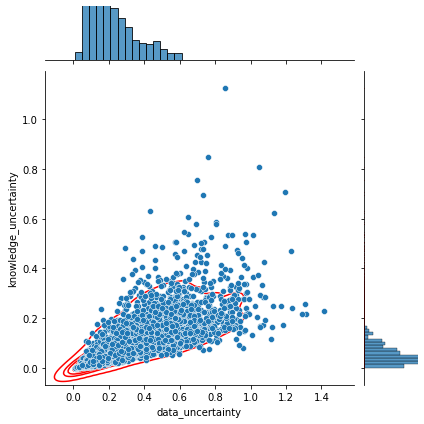

In [323]:
import matplotlib.pyplot as plt 
import seaborn as sns

g = sns.jointplot(
    data=uncertainty_df, 
    x='data_uncertainty', 
    y='knowledge_uncertainty',
    )

g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=True)

plt.show()

## Dataset 2

True data uncertainty (variance). The white region will not contain any traing data.


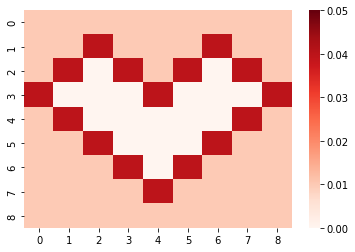

In [346]:
# function for generating mean and variance
def gen_parameters(noise=0.01, seed=0):
    
    np.random.seed(seed)
    
    mean = np.random.rand(9, 9)
    
    figure = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 4, 1, 1, 1, 4, 1, 1],
        [1, 4, 0, 4, 1, 4, 0, 4, 1],
        [4, 0, 0, 0, 4, 0, 0, 0, 4],
        [1, 4, 0, 0, 0, 0, 0, 4, 1],
        [1, 1, 4, 0, 0, 0, 4, 1, 1],
        [1, 1, 1, 4, 0, 4, 1, 1, 1],
        [1, 1, 1, 1, 4, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])

    var = figure*noise
    
    return mean, var
# generate parameters and plot variance
mean, var = gen_parameters()
print("True data uncertainty (variance). The white region will not contain any traing data.")
sns.heatmap(var, cmap="Reds", vmax=.05)
plt.show()

In [347]:
# function for generating train and validation sets
def generate_training_data(n_samples, mean, var, num_cat=9, seed=0):
    np.random.seed(seed)
    train = []
    target = []
    val = []
    val_target = []
    for i in range(num_cat):
        for j in range(num_cat):
            if var[i, j] == 0:
                continue
            for _ in range(n_samples):
                train.append([i, j])
                val.append([i, j])
                target.append(np.random.normal(mean[i, j], np.sqrt(var[i, j])))
                val_target.append(np.random.normal(mean[i, j], np.sqrt(var[i, j])))
                
    train = np.asarray(train)
    target = np.asarray(target)

    return train, target, val, val_target

In [348]:
# generate train and validation datasets
train, target, val, val_target = generate_training_data(1_000, mean, var)

# generate test, consisting of all possible feature combinations
num_cat = 9
test = np.asarray([[i, j] for i in range(num_cat) for j in range(num_cat)])

In [349]:
BRF = BayesianRandomForestRegressor()
BRF.fit(train, target)

True mean values (with mask):


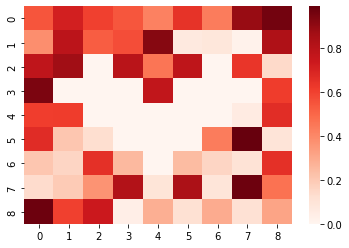

Predicted mean values (with mask):


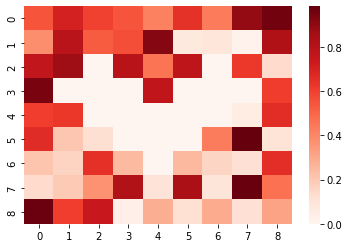

In [350]:
# define mask to hide elements inside the heart:
mask = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
    ])

print("True mean values (with mask):")
sns.heatmap(mean*mask, cmap="Reds")
plt.show()

print("Predicted mean values (with mask):")
mean_preds = BRF.predict(test)
sns.heatmap(mean_preds.reshape([num_cat, num_cat])*mask, cmap="Reds")
plt.show()

Knowledge uncertainty via ensemble:


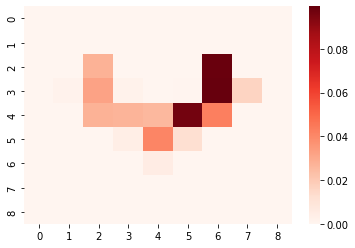

Average predicted data uncertainty:


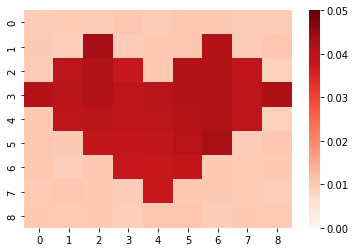

In [351]:
data = BRF.calc_data_uncertainty(test) # estimated data uncertainty
knowledge = BRF.calc_knowledge_uncertainty(test) # estimated knowledge uncertainty

print("Knowledge uncertainty via ensemble:")            
sns.heatmap(knowledge.reshape([num_cat, num_cat]), cmap="Reds")
plt.show()

print("Average predicted data uncertainty:")            
sns.heatmap(data.reshape([num_cat, num_cat]), cmap="Reds", vmin=0, vmax=0.05)
plt.show()